In [70]:
import mne
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim


In [ ]:
# Loading, preprocessing, and segmenting epochs
def load_epochs_for_subject(subject, runs, label):
    epochs_list = []
    labels_list = []
    edf_files = mne.datasets.eegbci.load_data(subject, runs)
    raw_list = []
    for f in edf_files:
        try:
            raw = mne.io.read_raw_edf(f, preload=True, verbose=False)
            raw_list.append(raw)
        except Exception as e:
            print(f"Error reading {f}: {e}")
            continue
    if not raw_list:
        return None, None
    raw = mne.concatenate_raws(raw_list)
    raw.pick_types(eeg=True)
    raw.filter(1, 40, fir_design='firwin', verbose=False)
    data, _ = raw.get_data(return_times=True)
    sfreq = raw.info['sfreq']
    channel_data = data[0]
    window_size = int(sfreq)
    stride = int(sfreq * 0.5)
    for start in range(0, len(channel_data) - window_size, stride):
        epochs_list.append(channel_data[start:start + window_size])
        labels_list.append(label)
    if epochs_list:
        return np.array(epochs_list), np.array(labels_list)
    else:
        return None, None

# Defining subjects and runs for movement and imagery conditions
subjects = range(1, 4)
movement_runs = [3, 5, 7, 9, 11, 13]
imagery_runs   = [4, 6, 8, 10, 12, 14]

all_epochs_list = []
all_labels_list = []
for subject in subjects:
    epochs, labels = load_epochs_for_subject(subject, movement_runs, label=0)
    if epochs is not None:
        all_epochs_list.append(epochs)
        all_labels_list.append(labels)
    epochs, labels = load_epochs_for_subject(subject, imagery_runs, label=1)
    if epochs is not None:
        all_epochs_list.append(epochs)
        all_labels_list.append(labels)

if not all_epochs_list:
    raise RuntimeError("No epochs loaded. Check dataset download and processing.")

all_epochs = np.concatenate(all_epochs_list, axis=0)
all_labels = np.concatenate(all_labels_list, axis=0)
print(f"Total epochs: {all_epochs.shape[0]}")

# Converting to tensors and splitting into training and test sets
epochs_tensor = torch.tensor(all_epochs, dtype=torch.float32).unsqueeze(-1)
labels_tensor = torch.tensor(all_labels, dtype=torch.long)
print("Epochs tensor shape:", epochs_tensor.shape)
print("Labels tensor shape:", labels_tensor.shape)
perm = torch.randperm(epochs_tensor.size(0))
epochs_tensor = epochs_tensor[perm]
labels_tensor = labels_tensor[perm]
split_idx = int(0.8 * epochs_tensor.size(0))
train_X, test_X = epochs_tensor[:split_idx], epochs_tensor[split_idx:]
train_y, test_y = labels_tensor[:split_idx], labels_tensor[split_idx:]
print("Training set shape:", train_X.shape)
print("Test set shape:", test_X.shape)

# LSTM-based EEG classifier
class EEGRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(EEGRNN, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.5)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

# Setting hyperparameters and model initialization
input_size = 32
hidden_size = 64
num_layers = 2
num_classes = 2
num_epochs = 10
batch_size = 32
learning_rate = 0.0001

model = EEGRNN(input_size, hidden_size, num_layers, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_dataset = torch.utils.data.TensorDataset(train_X, train_y)
test_dataset = torch.utils.data.TensorDataset(test_X, test_y)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X.view(batch_X.size(0), -1, input_size))
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * batch_X.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

# Evaluation
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X.view(batch_X.size(0), -1, input_size))
        _, predicted = torch.max(outputs, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()
print(f"Test Accuracy: {100 * correct / total:.2f}%")

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Total epochs: 8940
Epochs tensor shape: torch.Size([8940, 160, 1])
Labels tensor shape: torch.Size([8940])
Training set shape: torch.Size([7152, 160, 1])
Test set shape: torch.Size([1788, 160, 1])
Epoch [1/10], Loss: 0.6934
Epoch [2/10], Loss: 0.6932
Epoch [3/10], Loss: 0.6932
Epoch [4/10], Loss: 0.6933
Epoch [5/10], Loss: 0.6932
Epoch [6/10], Loss: 0.6933
Epoch [7/10], Loss: 0.6932
Epoch [8/10], Loss: 0.6932
Epoch [9/10], Loss: 0.6932
Epoch [10/10], Loss: 0.6933
Test Accuracy: 49.27%


Import libraries

Load and preprocessing Functions

In [ ]:
def load_epochs_for_subject(subject, runs, label):
    epochs_list = []
    labels_list = []
    
    # Loading EDF files
    edf_files = mne.datasets.eegbci.load_data(subject, runs)
    raw_list = []
    for f in edf_files:
        try:
            raw = mne.io.read_raw_edf(f, preload=True, verbose=False)
            raw_list.append(raw)
        except Exception as e:
            print(f"Error reading {f}: {e}")
            continue
    if not raw_list:
        return None, None
    raw = mne.concatenate_raws(raw_list)
    
    # Preprocessing raw data
    raw.pick_types(eeg=True)
    raw.filter(1, 40, fir_design='firwin', verbose=False)
    
    data, times = raw.get_data(return_times=True)
    sfreq = raw.info['sfreq']
    channel_data = data[0]
    
    # Segmenting data into epochs
    window_size = int(sfreq * 1)
    stride = int(sfreq * 0.5)
    for start in range(0, len(channel_data) - window_size, stride):
        epoch = channel_data[start:start + window_size]
        epochs_list.append(epoch)
        labels_list.append(label)
    
    if epochs_list:
        return np.array(epochs_list), np.array(labels_list)
    else:
        return None, None

Load and preprocess Data

In [ ]:
# Setting subjects and runs for movement and imagery
subjects = range(1, 4)
movement_runs = [3, 5, 7, 9, 11, 13]
imagery_runs = [4, 6, 8, 10, 12, 14]

all_epochs_list = []
all_labels_list = []

# Aggregating epochs from each subject and condition
for subject in subjects:
    epochs, labels = load_epochs_for_subject(subject, movement_runs, label=0)
    if epochs is not None:
        all_epochs_list.append(epochs)
        all_labels_list.append(labels)
    
    epochs, labels = load_epochs_for_subject(subject, imagery_runs, label=1)
    if epochs is not None:
        all_epochs_list.append(epochs)
        all_labels_list.append(labels)

# Combining epochs and labels across subjects
if all_epochs_list:
    all_epochs = np.concatenate(all_epochs_list, axis=0)
    all_labels = np.concatenate(all_labels_list, axis=0)
else:
    raise RuntimeError("No epochs loaded. Check dataset download and processing.")

print(f"Total epochs: {all_epochs.shape[0]}")

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Total epochs: 8940


EDA

Epochs shape: (8940, 160)
Labels shape: (8940,)
Class distribution:
Class 0: 4470 samples
Class 1: 4470 samples


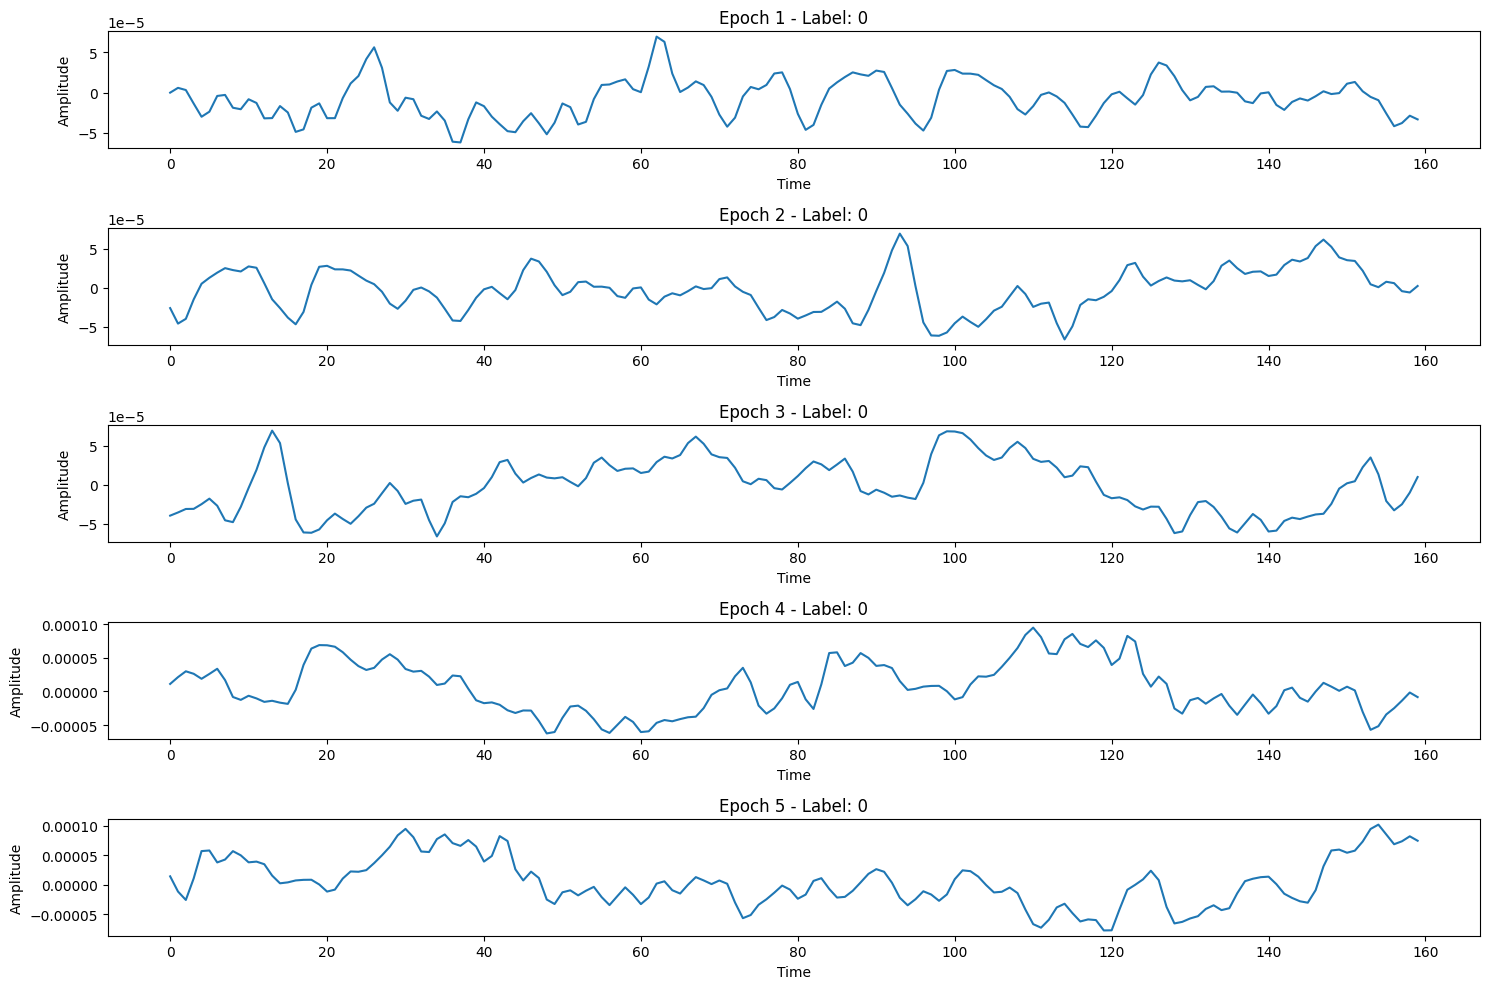

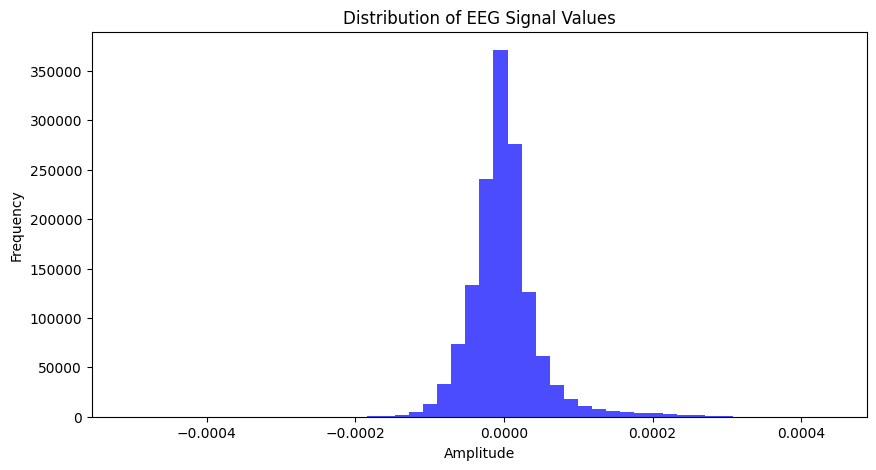

Mean of EEG signals: -0.0000
Standard deviation of EEG signals: 0.0000


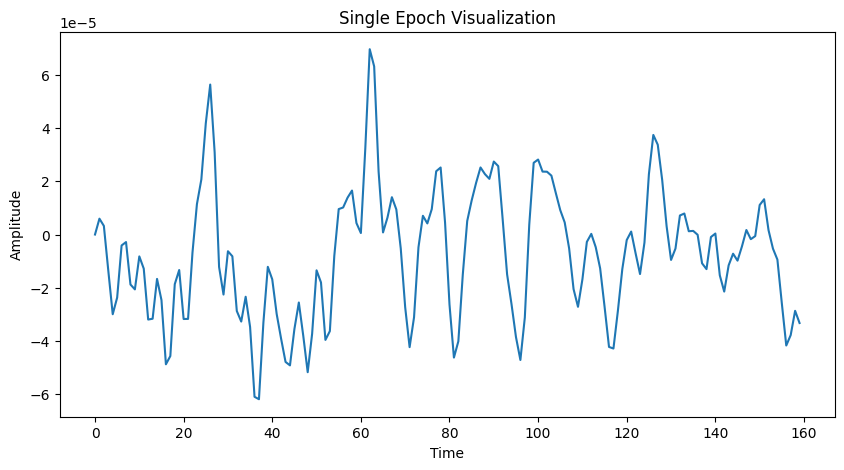

In [ ]:
import matplotlib.pyplot as plt

# Printing dataset shape
print(f"Epochs shape: {all_epochs.shape}")
print(f"Labels shape: {all_labels.shape}")

# Printing class distribution
unique, counts = np.unique(all_labels, return_counts=True)
print("Class distribution:")
for label, count in zip(unique, counts):
    print(f"Class {label}: {count} samples")

# Plotting example epochs
def plot_epochs(epochs, labels, num_samples=5):
    plt.figure(figsize=(15, 10))
    for i in range(num_samples):
        plt.subplot(num_samples, 1, i + 1)
        plt.plot(epochs[i])
        plt.title(f"Epoch {i + 1} - Label: {labels[i]}")
        plt.xlabel("Time")
        plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()

plot_epochs(all_epochs, all_labels)

# Plotting distribution of EEG signal values
plt.figure(figsize=(10, 5))
plt.hist(all_epochs.flatten(), bins=50, color='blue', alpha=0.7)
plt.title("Distribution of EEG Signal Values")
plt.xlabel("Amplitude")
plt.ylabel("Frequency")
plt.show()

# Printing mean and standard deviation of EEG signals
mean = np.mean(all_epochs)
std = np.std(all_epochs)
print(f"Mean of EEG signals: {mean:.4f}")
print(f"Standard deviation of EEG signals: {std:.4f}")

# Visualizing a single epoch
plt.figure(figsize=(10, 5))
plt.plot(all_epochs[0])
plt.title("Single Epoch Visualization")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

Convert Data to PyTorch Tensors

In [ ]:
# Normalizing epochs
all_epochs = (all_epochs - np.mean(all_epochs)) / np.std(all_epochs)
epochs_tensor = torch.tensor(all_epochs, dtype=torch.float32).unsqueeze(-1)
labels_tensor = torch.tensor(all_labels, dtype=torch.long)
perm = torch.randperm(epochs_tensor.size(0))
epochs_tensor = epochs_tensor[perm]
labels_tensor = labels_tensor[perm]

# Splitting into training, validation, and testing sets (70-15-15 split)
train_split = int(0.7 * epochs_tensor.size(0))
val_split = int(0.85 * epochs_tensor.size(0))

train_X, val_X, test_X = epochs_tensor[:train_split], epochs_tensor[train_split:val_split], epochs_tensor[val_split:]
train_y, val_y, test_y = labels_tensor[:train_split], labels_tensor[train_split:val_split], labels_tensor[val_split:]

print("Training set shape:", train_X.shape)
print("Validation set shape:", val_X.shape)
print("Test set shape:", test_X.shape)

Training set shape: torch.Size([6258, 160, 1])
Validation set shape: torch.Size([1341, 160, 1])
Test set shape: torch.Size([1341, 160, 1])


Define the LSTM Model


In [ ]:
class EEGRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(EEGRNN, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.5)  # Setting up LSTM layer
        self.fc = nn.Linear(hidden_size, num_classes)  # Setting up linear classifier

    def forward(self, x):
        out, _ = self.lstm(x)  # Processing input through LSTM
        out = self.fc(out[:, -1, :])  # Processing final time step for classification
        return out

Set Hyperparameters and Initialize Model

In [62]:
input_size = 1
hidden_size = 192
num_layers = 2
num_classes = 2
num_epochs = 10
batch_size = 32
learning_rate = 1.8960556375520513e-05

model = EEGRNN(input_size, hidden_size, num_layers, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

Train and test dataset

In [ ]:
# Creating TensorDatasets for training, validation, and testing
train_dataset = torch.utils.data.TensorDataset(train_X, train_y)
val_dataset = torch.utils.data.TensorDataset(val_X, val_y)
test_dataset = torch.utils.data.TensorDataset(test_X, test_y)

# Creating DataLoaders for training, validation, and testing
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Selecting computing device
print(f"Using device: {device}")

Using device: cuda


In [65]:
model = EEGRNN(input_size, hidden_size, num_layers, num_classes).to(device)

Training and validation phases

In [ ]:
for epoch in range(num_epochs):
    # Setting model to training mode
    model.train()
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        # Sending batch to device
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()  # Clearing gradients
        outputs = model(batch_X)  # Getting outputs
        loss = criterion(outputs, batch_y)  # Calculating loss
        loss.backward()  # Backpropagating loss
        optimizer.step()  # Updating parameters
        running_loss += loss.item() * batch_X.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    
    # Setting model to evaluation mode for validating
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            # Sending batch to device for validating
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)  # Getting outputs
            loss = criterion(outputs, batch_y)  # Calculating loss
            val_loss += loss.item() * batch_X.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
    val_loss /= len(val_loader.dataset)
    val_accuracy = 100 * correct / total
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

Epoch [1/10], Loss: 0.6936, Val Loss: 0.6957, Val Accuracy: 47.43%
Epoch [2/10], Loss: 0.6936, Val Loss: 0.6957, Val Accuracy: 47.43%
Epoch [3/10], Loss: 0.6936, Val Loss: 0.6957, Val Accuracy: 47.43%
Epoch [4/10], Loss: 0.6935, Val Loss: 0.6957, Val Accuracy: 47.43%
Epoch [5/10], Loss: 0.6936, Val Loss: 0.6957, Val Accuracy: 47.43%
Epoch [6/10], Loss: 0.6936, Val Loss: 0.6957, Val Accuracy: 47.43%
Epoch [7/10], Loss: 0.6936, Val Loss: 0.6957, Val Accuracy: 47.43%
Epoch [8/10], Loss: 0.6935, Val Loss: 0.6957, Val Accuracy: 47.43%
Epoch [9/10], Loss: 0.6936, Val Loss: 0.6957, Val Accuracy: 47.43%
Epoch [10/10], Loss: 0.6936, Val Loss: 0.6957, Val Accuracy: 47.43%


Evaluate the Model with test data

In [ ]:
model.eval()  # Setting model to evaluation mode
correct = 0
total = 0
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        _, predicted = torch.max(outputs.data, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()
print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 50.93%


Best Hyperparameters

In [ ]:
import optuna

def objective(trial):
    hidden_size = trial.suggest_int("hidden_size", 32, 256, step=32)
    num_layers = trial.suggest_int("num_layers", 1, 3)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
    dropout = trial.suggest_float("dropout", 0.2, 0.5)

    # Training model with hyperparameters
    return val_loss

study = optuna.create_study(direction="minimize")  # Creating study
study.optimize(objective, n_trials=50)  # Optimizing objective
print("Best hyperparameters:", study.best_params)  # Printing best hyperparameters

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-04-07 22:53:23,234] A new study created in memory with name: no-name-e1af5002-4403-4a2f-b7a6-d24abc0900d5
C:\Users\johan\AppData\Local\Temp\ipykernel_31124\2181488421.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
[I 2025-04-07 22:53:23,237] Trial 0 finished with value: 0.6934270812983303 and parameters: {'hidden_size': 192, 'num_layers': 2, 'learning_rate': 1.8960556375520513e-05, 'dropout': 0.30324516666756

Best hyperparameters: {'hidden_size': 192, 'num_layers': 2, 'learning_rate': 1.8960556375520513e-05, 'dropout': 0.3032451666675693}
